# Prediction of Patient Survival in the ICU 

## Team Member
Alice Wang: 

Christine Song:

Cindy Ren:

Emily Chen: jingyue_chen@hms.harvard.edu

Siheng Tao: 


## Problem Statement
Accurately predicting patient mortality in the intensive care unit (ICU) within the first 24 hours of admission is essential for effective triage, early prognosis, and informed clinical decision making. While data-driven models hold great potential to uncover factors influencing patient outcomes, the challenge lies in identifying the most relevant predictors within high-dimensional, incomplete ICU datasets. 

This project aims to utilize both __logistic regression and random forest models__ to estimate the risk of in-hospital mortality using data from the first 24 hours of ICU admission. Our objective is to identify a subset of key predictors that are both statistically significant and clinically interpretable, and to construct a predictive model that is practical and implementable in real-world ICU settings.

## Description of the Dataset
This project utilizes a publicly available dataset collected by MIT’s Global Open Source Severity of Illness Score (GOSSIS) community initiative. The dataset includes comprehensive clinical information from over 130,000 ICU visits recorded over the course of one year. Data were aggregated from more than 200 hospitals across multiple countries, including the United States, Argentina, Australia, New Zealand, Sri Lanka, and Brazil, reflecting a diverse and globally representative ICU population. The dataset’s target variable is hospital mortality, while the predictor variables include a wide range of clinically relevant features collected within the first 24 hours of ICU admission.

The datasets used for model training, selection, and evaluation in this project include:
- `training_v2.csv`: Contains 91,713 encounters along with associated clinical factors for model training.
- `unlabeled.csv`: Contains the same clinical features but lacks the `hospital_death` outcome; this dataset will be used for generating predictions.
- `WiDS Datathon 2020 Dictionary.csv`: Provides supplemental information on the dataset, including detailed descriptions of the predictors and clinical factors.

The response variable for this project is `hospital_death`, a binary outcome where 0 indicates the patient survived and 1 indicates the patient deceased. The remaining 185 columns serve as potential predictors. The objective is to perform feature selection to reduce the model to ≤10 non-collinear predictors, and then apply the simplified model to generate predictions on the unlabeled.csv dataset.

**Note**: Some columns may not be suitable as potential predictors. For example, `encounter_id` is unlikely to be informative for predicting `hospital_death`. The team will conduct a thorough manual review to identify and remove any columns that are not appropriate for inclusion as predictors.

In [18]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Issues

### 1. Data Missingness 
We first examined the missingness in our dataset. Excluding the response variable `hospital_death`, the dataset contains a total of 185 potential predictors. We performed a preliminary check on the percentage of missing values in each predictor and observed the following:
- 70 predictors have missingness ≤ 5%, where missing data can be imputed relatively confidently using standard imputation methods.
- 33 predictors have missingness between 5% and 20%.
- 82 predictors have missingness > 20%, making imputation more challenging and potentially less reliable.

We also examined data missingness in survived (`'hospital_death' == 0`) and deceased (`'hospital_death' == 1`) populations. The bars for both groups largely overlap at low missingness, suggesting missingness is fairly similar across the two groups for most predictors. At higher missingness, there is a slight difference, but overall it seems the missingness pattern is not drastically different between the groups.

Based on a review of the literature, we decided to select a cutoff value of [???]% to mitigate potential bias that may arise from handling missing data through imputation or alternative methods, depending on the nature of each predictor. The team will further discuss the most appropriate strategy for addressing missing values.

In [ ]:
df = pd.read_csv("data/training_v2.csv") # load the dataset
df.head() # exploratory summary of the dataset

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


Number of predictors with <= 5% missingness: 70
Number of predictors with 5-20% missingness: 33
Number of predictors with > 20% missingness: 82
Percentage of missingness in hospital_death: 0.0


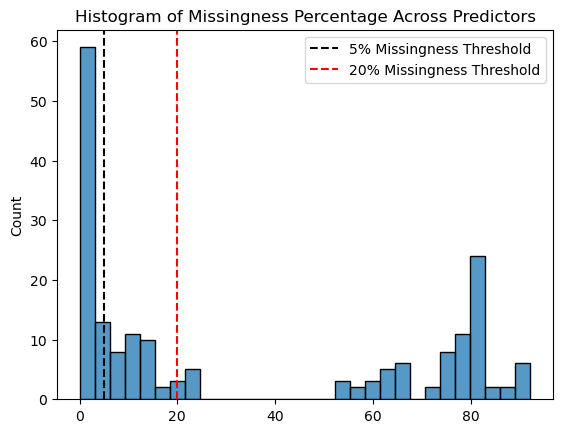

In [36]:
df.isna().sum()

# calculate persontage of missingness for each column
na_percent = df.isna().mean() * 100
na_percent = na_percent.drop('hospital_death') # drop response variable
na_percent = na_percent.sort_values(ascending=True)

# visualize percentage of missingness
fig, ax = plt.subplots()
sns.histplot(na_percent, bins=30, ax=ax)
ax.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax.set_title("Histogram of Missingness Percentage Across Predictors")
ax.legend()

# display stats
print(f'Number of predictors with <= 5% missingness: {sum(na_percent <= 5)}')
print(f'Number of predictors with 5-20% missingness: {sum((na_percent > 5) & (na_percent <= 20))}')
print(f'Number of predictors with > 20% missingness: {sum(na_percent > 20)}')

# calculate % missingness in response
print(f'Percentage of missingness in hospital_death: {df['hospital_death'].isna().mean() * 100}')

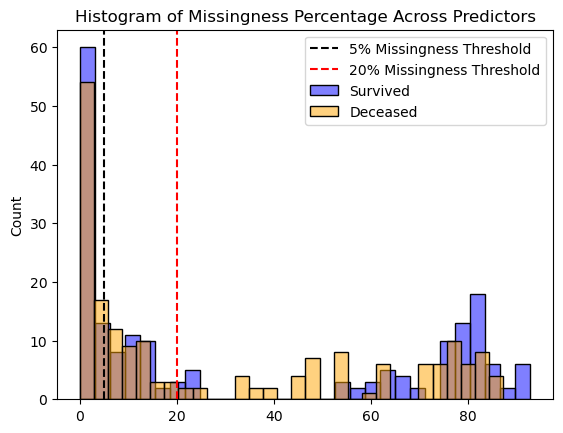

In [38]:
# visualize percentage of missingness by response variable
df_survived = df[df['hospital_death'] == 0]
df_deceased = df[df['hospital_death'] == 1]

fig, ax = plt.subplots()
sns.histplot(df_survived.isna().mean() * 100, bins=30, ax=ax, color='blue', alpha=0.5, label='Survived')
sns.histplot(df_deceased.isna().mean() * 100, bins=30, ax=ax, color='orange', alpha=0.5, label='Deceased')
ax.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax.set_title("Histogram of Missingness Percentage Across Predictors")
ax.legend()

### 2. Data Imbalance
We examined the class distribution of our target variable `hospital_death`, and found a significant imbalance: 83,798 patients survived, while 7,915 patients did not. Due to this pronounced imbalance, we decided to incorporate resampling techniques during model training to mitigate its impact and improve the model’s performance on the minority class.

In [10]:
df['hospital_death'].value_counts()

hospital_death
0    83798
1     7915
Name: count, dtype: int64

### 3. Data Scaling
Most features have very small ranges, clustered near zero, while a few features have extremely large ranges (e.g., one reaching ~130,000). This is a classic case of features on widely different scales, meaning some features could dominate model training if not scaled.

Text(0, 0.5, 'Number of Features')

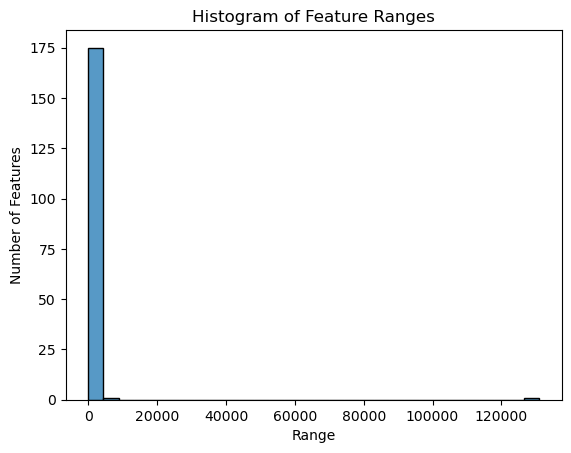

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('encounter_id')
df[numeric_cols].describe() # exploratory summary

# visualize feature ranges
ranges = df[numeric_cols].max() - df[numeric_cols].min()
fig, ax = plt.subplots()
sns.histplot(ranges, bins=30, edgecolor='k')
ax.set_title("Histogram of Feature Ranges")
ax.set_xlabel("Range")
ax.set_ylabel("Number of Features")